# Mixture Models

In this tutorial, we will look at Gaussian and Bernoulli mixture models. These mixture models are defined by mixing distribution (categorical) which is responsible for defining the distribution over the component distributions. We will train these models to generatively model MNIST data sets. We can train them with both expectation maximization (EM) or gradient descent based approaches.

In [1]:
import equinox as eqx
import jax
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow_datasets as tfds
from jax import numpy as jnp
from jax.scipy.special import expit, logit
from tqdm.notebook import tqdm

from distreqx.distributions import (
    Bernoulli,
    Categorical,
    Independent,
    MixtureSameFamily,
    Normal,
)

In [2]:
N = 2_000
mnist_data = tfds.load("mnist")["train"]
mnist_data = tfds.as_numpy(mnist_data)
mnist_data = jnp.array(
    [data["image"] for count, data in enumerate(mnist_data) if count < N]
)

2025-08-11 12:24:18.473070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
new_data = mnist_data / 255.0
new_data.shape

(2000, 28, 28, 1)

In [4]:
class GMM(eqx.Module):
    _model: MixtureSameFamily

    def __init__(self, K, n_vars, rng_key):
        mixing_coeffs = jax.random.uniform(rng_key, (K,), minval=100, maxval=200)
        mixing_coeffs = mixing_coeffs / mixing_coeffs.sum()
        initial_probs = jnp.full((K, n_vars), 1.0 / K)

        self._model = MixtureSameFamily(
            mixture_distribution=Categorical(probs=mixing_coeffs),
            components_distribution=Independent(
                Normal(initial_probs, 0.2 * jnp.ones_like(initial_probs))
            ),
        )

    @property
    def mixing_coeffs(self):
        return self._model.mixture_distribution.probs

    @property
    def probs(self):
        return self._model.components_distribution.distribution.loc

    @property
    def model(self):
        return self._model

    def responsibilities(self, observations):
        return jnp.nan_to_num(self._model.posterior_marginal(observations).probs)

    def expected_log_likelihood(self, observations):
        return jnp.nan_to_num(self._model.log_prob(observations))

    def em_step(self, observations):
        n_obs, _ = observations.shape

        res = eqx.filter_vmap(self.responsibilities)(observations)
        sum_res = jnp.sum(res, axis=0)
        mus = jax.vmap(
            lambda c, d: jax.vmap(lambda a, b: a * b, in_axes=(0, None))(c, d)
        )(res, observations)
        mus = jax.vmap(lambda a, b: a / b)(jnp.sum(mus, axis=0), sum_res)
        # constant sigma
        return sum_res / n_obs, mus

    def plot(self, n_row, n_col):
        if n_row * n_col != len(self.mixing_coeffs):
            raise TypeError(
                "The number of rows and columns does not match with "
                "the number of component distribution."
            )
        fig, axes = plt.subplots(n_row, n_col)

        for (coeff, mean), ax in zip(
            zip(self.mixing_coeffs, self.probs), axes.flatten()
        ):
            ax.imshow(mean.reshape((28, 28)), cmap="grey")
            ax.set_title("%1.2f" % coeff)
            ax.axis("off")

        fig.tight_layout(pad=1.0)
        plt.show()

Here we have some manual updates, this is in general not necessary, but can be helpful to have more direct control over the parameters (especially given the nature of modules to be very deep).

  0%|          | 0/20 [00:00<?, ?it/s]

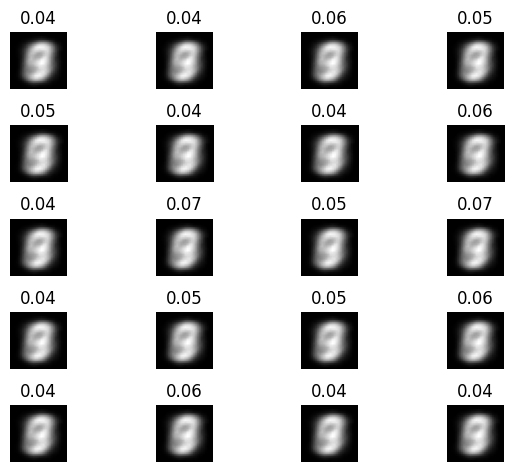

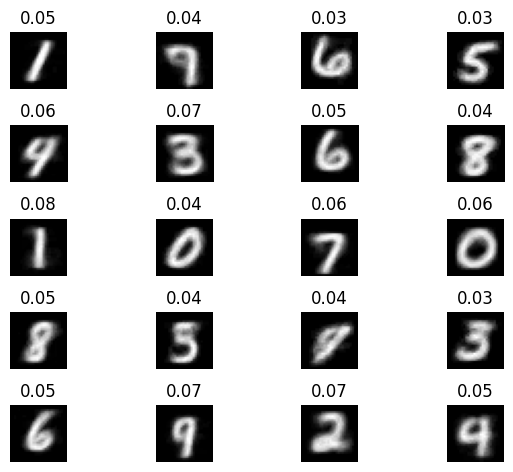

In [5]:
@eqx.filter_jit
def update_model_params(model, params):
    model = eqx.tree_at(
        lambda x: x._model.mixture_distribution._probs, model, params[0]
    )
    model = eqx.tree_at(
        lambda x: x._model.components_distribution.distribution._loc, model, params[1]
    )
    return model


@eqx.filter_jit
def train_step(model, params, observations):
    model = update_model_params(model, params)
    log_likelihood = jnp.sum(
        eqx.filter_vmap(model.expected_log_likelihood)(observations)
    )
    mixing_coeffs, probs = model.em_step(observations)
    return (mixing_coeffs, probs), log_likelihood


data = new_data.reshape((N, 784))
data = ((data > 0.0).astype("int32") + 1e-8) * 0.99
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
K = 20
model = GMM(K, 784, subkey)
params = (model.mixing_coeffs, model.probs)

batch_size = 2000
inner = N // batch_size
outer = 20
losses = []

for epoch in tqdm(range(outer)):
    inner_loss = []
    for batch in range(inner):
        key, subkey = jax.random.split(key)
        inds = jax.random.randint(
            subkey, minval=0, maxval=len(data), shape=(batch_size,)
        )
        real_batch = data[inds]
        key, subkey = jax.random.split(key)
        params, loss = train_step(model, params, real_batch)
        model = update_model_params(model, params)
        inner_loss.append(loss)

    losses.append(np.mean(inner_loss))

    if epoch % 10 == 0:
        model.plot(5, 4)

Now lets plot the EM loss and the final generated images for the GMM.

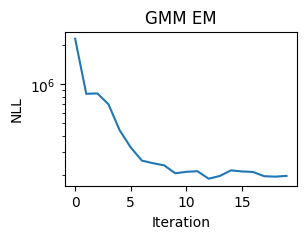

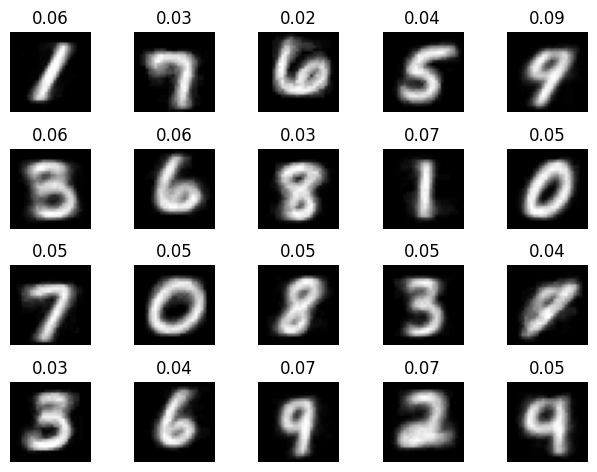

In [9]:
plt.figure(figsize=(3, 2))
plt.plot(-np.array(losses))
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.title("GMM EM")
plt.show()

model.plot(4, 5)

Now we can repeat the process, but with SGD this time instead of EM. Notice the different failure mode? Difficulties in training mixtures models with SGD are well known (and there are many variants of EM to help overcome these failure modes).

  0%|          | 0/100 [00:00<?, ?it/s]

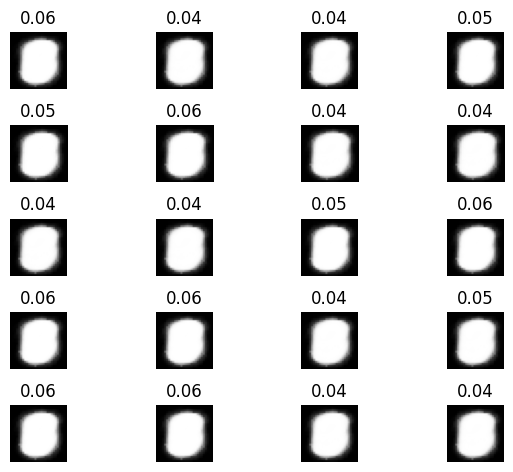

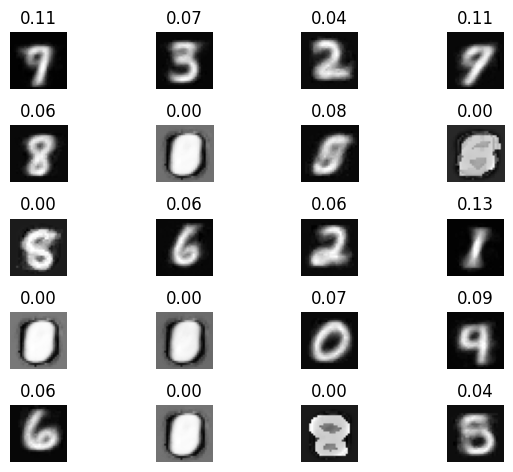

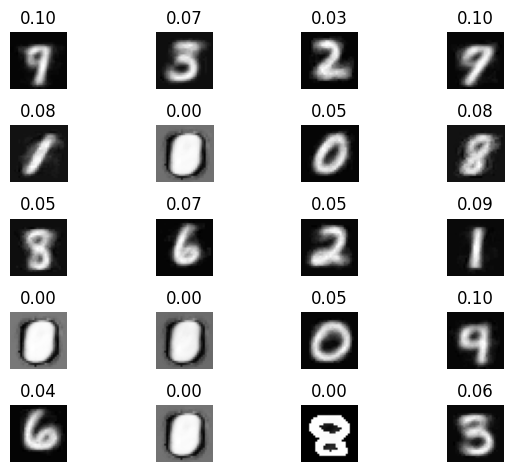

In [10]:
@eqx.filter_jit
def update_model_params(model, params):
    params = (jax.nn.softmax(params[0]), params[1])
    model = eqx.tree_at(
        lambda x: x._model.mixture_distribution._probs, model, params[0]
    )
    model = eqx.tree_at(
        lambda x: x._model.components_distribution.distribution._loc, model, params[1]
    )
    return model


def loss_fn(model, params, inp):
    model = update_model_params(model, params)
    return -model.expected_log_likelihood(inp)


def vmap_loss(params, model, batch):
    return jnp.mean(
        eqx.filter_vmap(loss_fn, in_axes=(None, None, 0))(model, params, batch)
    )


@eqx.filter_jit
def step(model, params, batch, opt_state):
    loss, grads = eqx.filter_value_and_grad(vmap_loss)(params, model, batch)
    update, opt_state = optimizer.update(grads, opt_state, params)
    params = eqx.apply_updates(params, update)
    return params, opt_state, loss


data = new_data.reshape((N, 784))
data = (data > 0.0).astype("int32")
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
K = 20
model = GMM(K, 784, subkey)
params = (model.mixing_coeffs, model.probs)
optimizer = optax.adam(1e-1)
opt_state = optimizer.init((jax.nn.softmax(model.mixing_coeffs), model.probs))

batch_size = 1000
inner = N // batch_size
outer = 100
losses = []

for epoch in tqdm(range(outer)):
    inner_loss = []
    for batch in range(inner):
        key, subkey = jax.random.split(key)
        inds = jax.random.randint(
            subkey, minval=0, maxval=len(data), shape=(batch_size,)
        )
        real_batch = data[inds]
        key, subkey = jax.random.split(key)
        params, opt_state, loss = step(model, params, real_batch, opt_state)
        model = update_model_params(model, params)
        inner_loss.append(loss)

    losses.append(np.mean(inner_loss))
    if epoch % 40 == 0:
        model.plot(5, 4)

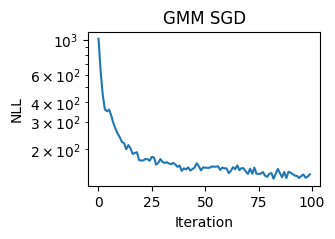

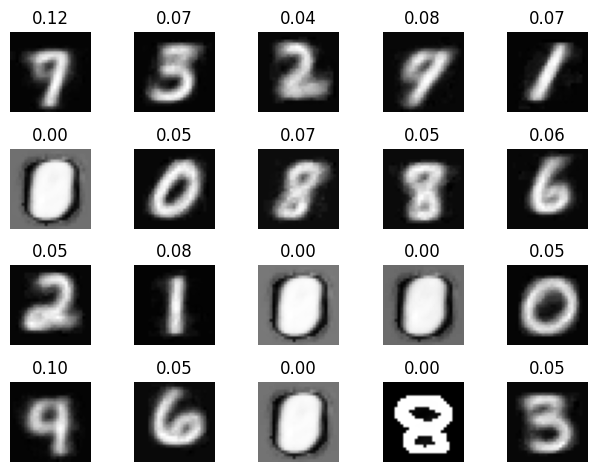

In [11]:
plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.title("GMM SGD")
plt.show()

model.plot(4, 5)

## Bernoulli Mixture Models

Now we can repeat the exact process as before, but with the component distribution being a Bernoulli. Once you've completed this tutorial, try it with a different distribution and see how it works!

In [12]:
class BMM(eqx.Module):
    _model: MixtureSameFamily

    def __init__(self, K, n_vars, rng_key):
        mixing_coeffs = jax.random.uniform(rng_key, (K,), minval=100, maxval=200)
        mixing_coeffs = mixing_coeffs / mixing_coeffs.sum()
        initial_probs = jnp.full((K, n_vars), 1.0 / K)

        self._model = MixtureSameFamily(
            mixture_distribution=Categorical(probs=mixing_coeffs),
            components_distribution=Independent(Bernoulli(probs=initial_probs)),
        )

    @property
    def mixing_coeffs(self):
        return self._model.mixture_distribution.probs

    @property
    def probs(self):
        return self._model.components_distribution.distribution.probs

    @property
    def model(self):
        return self._model

    def responsibilities(self, observations):
        return jnp.nan_to_num(self._model.posterior_marginal(observations).probs)

    def expected_log_likelihood(self, observations):
        return jnp.nan_to_num(self._model.log_prob(observations))

    def em_step(self, observations):
        n_obs, _ = observations.shape

        def m_step_per_bernoulli(responsibility):
            norm_const = responsibility.sum()
            mu = jnp.sum(responsibility[:, None] * observations, axis=0) / norm_const
            return jax.numpy.nan_to_num(mu), jax.numpy.nan_to_num(norm_const)

        mus, ns = eqx.filter_vmap(m_step_per_bernoulli, in_axes=(1))(
            eqx.filter_vmap(self.responsibilities)(observations)
        )
        return ns / n_obs, mus

    def plot(self, n_row, n_col):
        if n_row * n_col != len(self.mixing_coeffs):
            raise TypeError(
                "The number of rows and columns does not match with the "
                "number of component distribution."
            )
        fig, axes = plt.subplots(n_row, n_col)

        for (coeff, mean), ax in zip(
            zip(self.mixing_coeffs, self.probs), axes.flatten()
        ):
            ax.imshow(mean.reshape((28, 28)), cmap="grey")
            ax.set_title("%1.2f" % coeff)
            ax.axis("off")

        fig.tight_layout(pad=1.0)
        plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

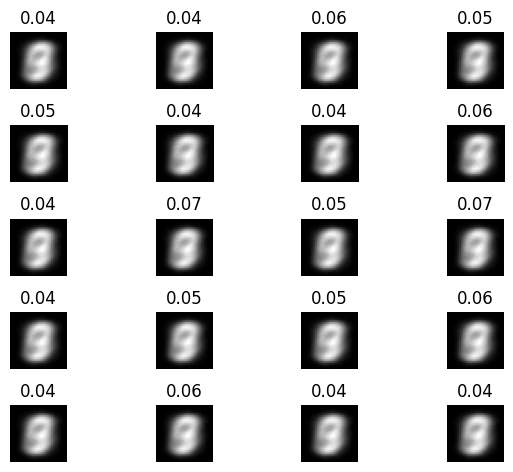

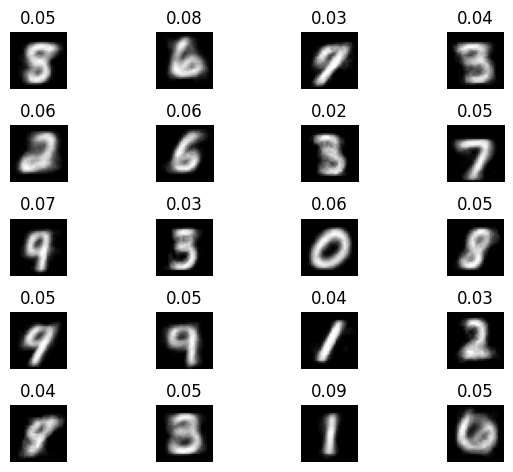

In [13]:
@eqx.filter_jit
def update_model_params(model, params):
    model = eqx.tree_at(
        lambda x: x._model.mixture_distribution._probs, model, params[0]
    )
    model = eqx.tree_at(
        lambda x: x._model.components_distribution.distribution._probs, model, params[1]
    )
    return model


@eqx.filter_jit
def train_step(model, params, observations):
    model = update_model_params(model, params)
    log_likelihood = jnp.sum(
        eqx.filter_vmap(model.expected_log_likelihood)(observations)
    )
    mixing_coeffs, probs = model.em_step(observations)
    return (mixing_coeffs, probs), log_likelihood


data = new_data.reshape((N, 784))
data = ((data > 0.0).astype("int32") + 1e-8) * 0.99
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
K = 20
model = BMM(K, 784, subkey)
params = (model.mixing_coeffs, model.probs)

batch_size = 2000
inner = N // batch_size
outer = 20
losses = []

for epoch in tqdm(range(outer)):
    inner_loss = []
    for batch in range(inner):
        key, subkey = jax.random.split(key)
        inds = jax.random.randint(
            subkey, minval=0, maxval=len(data), shape=(batch_size,)
        )
        real_batch = data[inds]
        key, subkey = jax.random.split(key)
        params, loss = train_step(model, params, real_batch)
        model = update_model_params(model, params)
        inner_loss.append(loss)

    losses.append(np.mean(inner_loss))

    if epoch % 10 == 0:
        model.plot(5, 4)

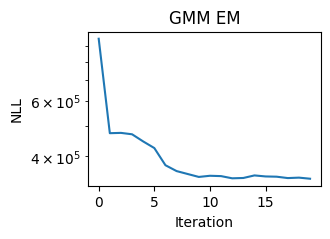

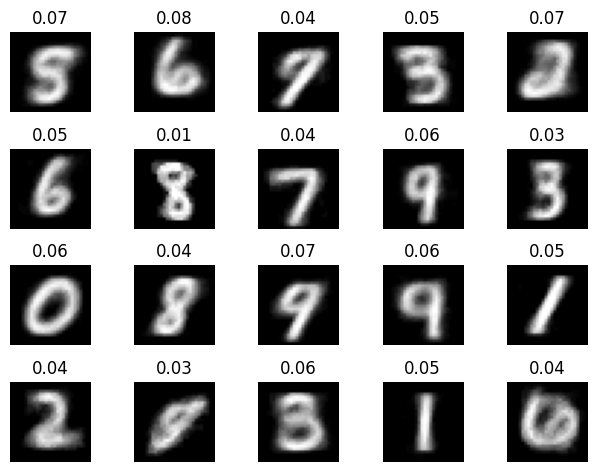

In [14]:
plt.figure(figsize=(3, 2))
plt.plot(-np.array(losses))
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.title("GMM EM")
plt.show()
model.plot(4, 5)

  0%|          | 0/100 [00:00<?, ?it/s]

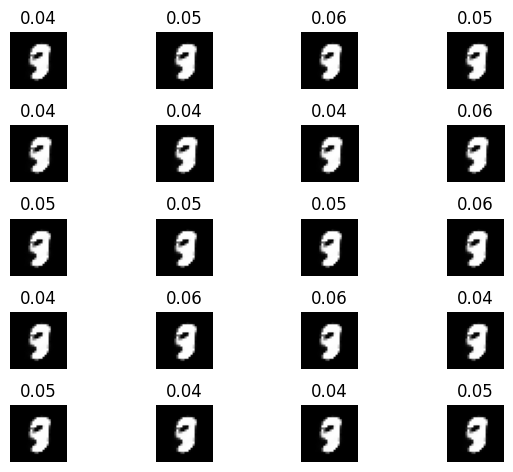

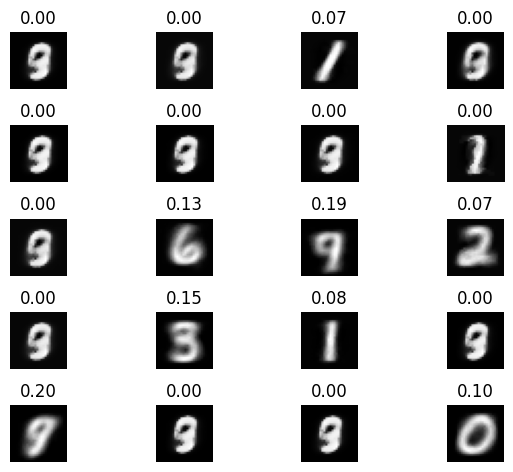

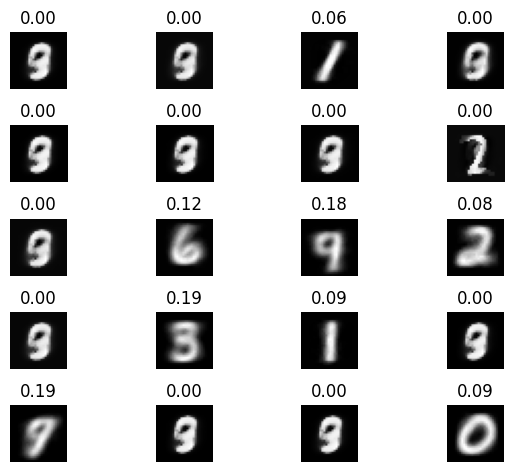

In [27]:
# todo: this is annoying, fix
@eqx.filter_jit
def update_model_params(model, params):
    params = (jax.nn.softmax(params[0]), expit(params[1]))
    model = eqx.tree_at(
        lambda x: x._model.mixture_distribution._probs, model, params[0]
    )
    model = eqx.tree_at(
        lambda x: x._model.components_distribution.distribution._probs, model, params[1]
    )
    return model


@eqx.filter_jit
def step(model, params, batch, opt_state):
    batch = batch.astype("float32")
    loss, grads = eqx.filter_value_and_grad(vmap_loss)(params, model, batch)
    update, opt_state = optimizer.update(grads, opt_state, params)
    params = eqx.apply_updates(params, update)
    return params, opt_state, loss


data = new_data.reshape((N, 784))
data = (data > 0.0).astype("int32")
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
K = 20
model = BMM(K, 784, subkey)
params = (model.mixing_coeffs, model.probs)
optimizer = optax.adam(1e-1)
opt_state = optimizer.init((jax.nn.softmax(model.mixing_coeffs), logit(model.probs)))

batch_size = 1000
inner = N // batch_size
outer = 100
losses = []

for epoch in tqdm(range(outer)):
    inner_loss = []
    for batch in range(inner):
        key, subkey = jax.random.split(key)
        inds = jax.random.randint(
            subkey, minval=0, maxval=len(data), shape=(batch_size,)
        )
        real_batch = data[inds]
        key, subkey = jax.random.split(key)
        params, opt_state, loss = step(model, params, real_batch, opt_state)
        model = update_model_params(model, params)
        inner_loss.append(loss)

    losses.append(np.mean(inner_loss))
    if epoch % 40 == 0:
        model.plot(5, 4)

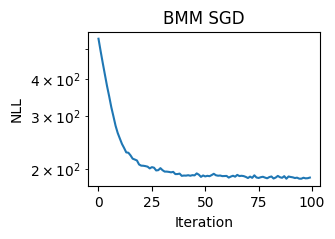

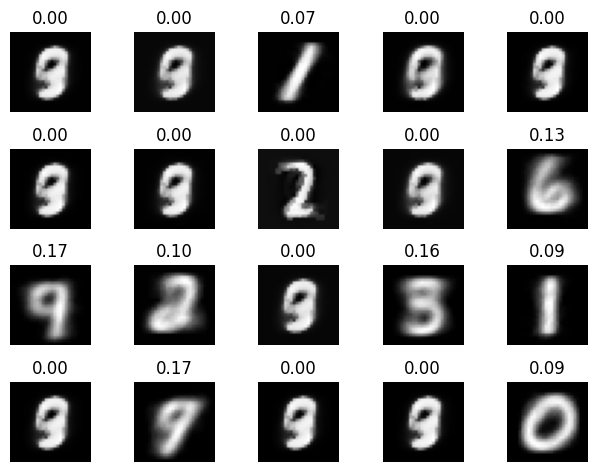

In [28]:
plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.title("BMM SGD")
plt.show()
model.plot(4, 5)